In [39]:
# topic modeling / clustering options 

# LDA
# GSDMM (Gibb's sampling, ideal for short text)
# BERT + Cosine Similarity clustering (DBSCAN?)

SOLUTION ARCHITECTURE

1. Assign "popularity" score to each comment by weighting others' opinions of each comment

2. Assign each comment a topic - optimize number of topics

3. Rank each topic by popularity (using topic score and popularity of each comment within that topic to weight total comments within that topic) 

4. Show the most representative comment and most popular comment from each topic to the moderator along with word cloud of topic's corpus(minus SW)

In [ ]:
# install transformers and pytorch as well for sent2vec

In [158]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

# Text pre-processing tools
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from gensim.utils import simple_preprocess
from nltk.stem import PorterStemmer

# LDA
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# LDA Visualization
import pyLDAvis
import pyLDAvis.gensim_models

# BERT vectorization
#from scipy import spatial
#from sent2vec.vectorizer import Vectorizer

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The question posed is:

What features do you like about the social media platforms that you use? 

How do we summarize the participants answers to the moderator? 

In [159]:
# Import relevant data. 
thoughts = pd.read_csv('thoughts.csv')
binary_choices = pd.read_csv('binary_choices.csv')
agreements = pd.read_csv('agreements.csv')

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Import and Preview Data

## Comments

In [160]:
# Preview data. 
thoughts.head(60)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,respondent_id,text
0,0,17,It's easy to use and very heavily adopted by other people.
1,1,38,Easy access is just about the only thing.
2,2,23,youtube makes it really easy to see what kind of an audience my videos have and how people access them
3,3,5,Being able to mute/block people. It helps keep the feed clean
4,4,25,Being able to share content
5,5,34,"Ease of use, popularity. There is much that you can do."
6,6,6,Blocking
7,7,37,Few. Most of it is useless
8,8,0,I love seeing other people's pictures and being able to communicate easily
9,9,27,The ability to set my profile to private.


Common themes from initial look:
* Easy to use and network effect (popular)
* Blocking / unfollowing / muting / filtering (seeing what I don't want to see)
* Built-in apps (audio/video chat, sending/receiving money, "stories")
* Friends/family connection
* Nothing to contribute (negative impression) - possibly use sentiment model to remove these comments; tell the 'audience' that X proportion of users are not in favor of social media; idx (7,11,20) - how many people agree with these statements?
* Privacy / control
* Photos/pictures

Other impressions:
* Specific entities (i.e. YouTube should probably be removed)

In [161]:
### USE THIS DATA TO 'WEIGHT' THE RELEVANCE OF THOUGHTS - HOW MANY PEOPLE AGREE RELATIVE TO HOW MANY WERE EXPOSED? 

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Binary Choices

In [162]:
# Preview data. 
binary_choices.head(60)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,respondent_id,thought_a_id,thought_b_id,label
0,32,20,14,A
1,29,19,21,A
2,37,6,19,A
3,32,35,5,A
4,37,8,6,B
5,32,14,18,B
6,32,11,16,A
7,32,6,32,B
8,32,3,38,B
9,32,1,8,A


In [163]:
# Preview data. 
binary_choices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   respondent_id  147 non-null    int64 
 1   thought_a_id   147 non-null    int64 
 2   thought_b_id   147 non-null    int64 
 3   label          147 non-null    object
dtypes: int64(3), object(1)
memory usage: 4.7+ KB


C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [164]:
# every comment presented at least once
thoughts_offered_for_binary_choice = pd.concat([binary_choices['thought_a_id'], binary_choices['thought_b_id']])
len(set(thoughts_offered_for_binary_choice))

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


41

In [165]:
Counter(thoughts_offered_for_binary_choice)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({20: 10,
         19: 11,
         6: 10,
         35: 11,
         8: 10,
         14: 5,
         11: 11,
         3: 8,
         1: 12,
         31: 9,
         2: 3,
         13: 8,
         39: 7,
         18: 11,
         0: 4,
         7: 6,
         12: 20,
         23: 3,
         4: 10,
         16: 4,
         15: 7,
         22: 9,
         9: 8,
         10: 9,
         32: 4,
         17: 8,
         24: 4,
         21: 3,
         40: 2,
         28: 4,
         29: 6,
         30: 6,
         26: 5,
         36: 9,
         25: 10,
         38: 7,
         5: 7,
         37: 2,
         33: 5,
         34: 2,
         27: 4})

## Agreements

In [166]:
# preview data
agreements.head(60)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,respondent_id,thought_id,label
0,32,7,Disagree
1,37,3,Agree
2,37,1,Disagree
3,37,14,Disagree
4,37,19,Disagree
5,24,4,Agree
6,32,39,Agree
7,37,38,Disagree
8,6,18,Agree
9,6,1,Disagree


In [167]:
agreements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   respondent_id  268 non-null    int64 
 1   thought_id     268 non-null    int64 
 2   label          268 non-null    object
dtypes: int64(2), object(1)
memory usage: 6.4+ KB


C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
# every comment used at least once
len(set(agreements['thought_id']))

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


41

In [169]:
Counter(agreements['thought_id'])

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Counter({7: 7,
         3: 10,
         1: 10,
         14: 14,
         19: 11,
         4: 11,
         39: 9,
         38: 6,
         18: 7,
         9: 10,
         21: 5,
         5: 1,
         37: 2,
         11: 6,
         29: 6,
         8: 10,
         6: 8,
         31: 9,
         20: 7,
         40: 5,
         2: 4,
         23: 7,
         15: 11,
         0: 5,
         16: 7,
         13: 11,
         28: 4,
         35: 5,
         34: 4,
         27: 1,
         10: 7,
         17: 8,
         24: 8,
         30: 2,
         25: 6,
         22: 7,
         36: 3,
         33: 4,
         26: 3,
         32: 3,
         12: 4})

# Assign Popularity Score to Each Comment Using Meta Data

In order to best understand how strong a particular opinion is amongst the entire audience we will assign a score to each comment. This score will be based on how many agreements and preferences a thought receives. 

In [170]:
# Add column showing respondent thought preference. 
binary_choices['thought_preference'] = binary_choices.apply(lambda row: row['thought_a_id'] if row['label'] == 'A' else row['thought_b_id'], axis=1)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [171]:
# Iterate through thoughts df and show if thought is shared by others. 
for idx, row in thoughts.iterrows():
    # Identify thought id. 
    thought_id = thoughts.loc[idx,'id']
    
    # Agreements popularity
    
    # Count total agreement proposals and agreements.
    total_proposed_agreements = len(agreements[agreements['thought_id'] == thought_id])
    total_agreements = len(agreements[(agreements['thought_id'] == thought_id) &
                                      (agreements['label'] == 'Agree')])
    
    # Create agreement popularity score and add to thoughts dataframe
    thoughts.loc[idx,'agreement_popularity_score'] = total_agreements / total_proposed_agreements
    
    # Binary choice popularity
    
    # Count total binary choice proposals and preferences. 
    total_proposed_preferences = len(binary_choices[binary_choices['thought_a_id'] == thought_id]) + \
                                 len(binary_choices[binary_choices['thought_b_id'] == thought_id])
    
    total_preferences = len(binary_choices[binary_choices['thought_preference'] == thought_id])
    
    # Create binary choice popularity score and add to thoughts dataframe. 
    binary_choice_popularity_score = total_preferences / total_proposed_preferences
    
    # Add binary choice popularity score to thoughts dataframe
    thoughts.loc[idx,'binary_choice_popularity_score'] = total_preferences / total_proposed_preferences
    
    # Assign popularity score weights.
    binary_popularity_weight = total_proposed_preferences / (total_proposed_preferences + total_proposed_agreements)
    agreement_popularity_weight = total_proposed_agreements / (total_proposed_preferences + total_proposed_agreements)
    
    # Add popularity score to thoughts df
    thoughts['popularity'] = thoughts.apply(lambda row: agreement_popularity_weight*(row['agreement_popularity_score']) + \
                                                        binary_popularity_weight*(row['binary_choice_popularity_score']), 
                                                        axis=1)
    
    # Add alternative equally weighted popularity score to thoughts df
    thoughts['equally_weighted_popularity'] = thoughts.apply(lambda row: 0.5*(row['agreement_popularity_score']) + \
                                                                         0.5*(row['binary_choice_popularity_score']), 
                                                                         axis=1)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
thoughts.sort_values(by='popularity', ascending=False)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,respondent_id,text,agreement_popularity_score,binary_choice_popularity_score,popularity,equally_weighted_popularity
18,18,31,Seeing pictures and posts from my friends/family,1.000000,0.818182,0.948052,0.909091
32,32,28,I like how I can see the latest posts from the people I follow.,1.000000,0.750000,0.928571,0.875000
29,29,26,"connection, simplicity, convenience",0.833333,1.000000,0.880952,0.916667
27,27,4,I like that I can choose who to have on my friends list and not accept request from those that I don't want to know what me or my family are up to every minute of the day,1.000000,0.500000,0.857143,0.750000
3,3,5,Being able to mute/block people. It helps keep the feed clean,1.000000,0.375000,0.821429,0.687500
25,25,32,Being able to keep in contact with others,0.833333,0.700000,0.795238,0.766667
6,6,6,Blocking,0.875000,0.500000,0.767857,0.687500
15,15,21,I enjoy the stories features a lot.,0.727273,0.714286,0.723562,0.720779
17,17,30,it allows me to easily keep in touch with people I care about,0.750000,0.625000,0.714286,0.687500
26,26,1,"Ability to see updates in real time, ability to keep up with friends/family.",0.666667,0.800000,0.704762,0.733333


# Cleaning and Tokenizing Thoughts

## Tokenize Thoughts

In [193]:
# Tokenize data with Gensim. 
thoughts['tokens'] = thoughts['text'].apply(lambda x: simple_preprocess(x, deacc=True))

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [194]:
thoughts

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,respondent_id,text,agreement_popularity_score,binary_choice_popularity_score,popularity,equally_weighted_popularity,tokens,topic,topic_strength
37,37,40,"Meet and chat with new people, especially around weird hobbies, and learn a lot more about those hobbies or weird interests. Like hot sauce, or russian literature, etc.",0.500000,1.000000,0.642857,0.750000,"[meet, and, chat, with, new, people, especially, around, weird, hobbies, and, learn, lot, more, about, those, hobbies, or, weird, interests, like, hot, sauce, or, russian, literature, etc]",0,0.988215
10,10,35,"Easy voice and video chat, easy payments options for sending and receiving money, lots of controls to control the broadcasting of my data",0.714286,0.333333,0.605442,0.523810,"[easy, voice, and, video, chat, easy, payments, options, for, sending, and, receiving, money, lots, of, controls, to, control, the, broadcasting, of, my, data]",2,0.985573
27,27,4,I like that I can choose who to have on my friends list and not accept request from those that I don't want to know what me or my family are up to every minute of the day,1.000000,0.500000,0.857143,0.750000,"[like, that, can, choose, who, to, have, on, my, friends, list, and, not, accept, request, from, those, that, don, want, to, know, what, me, or, my, family, are, up, to, every, minute, of, the, day]",1,0.982288
39,39,33,"Keep in touch with family that lives far away, and seeing pictures from friends and family that live close.",0.444444,0.714286,0.521542,0.579365,"[keep, in, touch, with, family, that, lives, far, away, and, seeing, pictures, from, friends, and, family, that, live, close]",0,0.981528
19,19,14,I think the best feature is that I can easily communicate with my friends and family. It's much easier when everyone is on the same platform.,0.727273,0.545455,0.675325,0.636364,"[think, the, best, feature, is, that, can, easily, communicate, with, my, friends, and, family, it, much, easier, when, everyone, is, on, the, same, platform]",1,0.980725
12,12,13,I like being able to unfollow the idiots who repeatedly think the orange blob is sent from God.,0.750000,0.300000,0.621429,0.525000,"[like, being, able, to, unfollow, the, idiots, who, repeatedly, think, the, orange, blob, is, sent, from, god]",0,0.977952
2,2,23,youtube makes it really easy to see what kind of an audience my videos have and how people access them,0.500000,0.333333,0.452381,0.416667,"[youtube, makes, it, really, easy, to, see, what, kind, of, an, audience, my, videos, have, and, how, people, access, them]",0,0.977945
21,21,10,"Easy to use and is updated regularly for new features, fix bugs, etc",0.600000,0.000000,0.428571,0.300000,"[easy, to, use, and, is, updated, regularly, for, new, features, fix, bugs, etc]",1,0.976596
33,33,22,The immediacy of the interaction. By the time the evening news comes on I already know everything on it.,0.500000,0.600000,0.528571,0.550000,"[the, immediacy, of, the, interaction, by, the, time, the, evening, news, comes, on, already, know, everything, on, it]",2,0.976298
26,26,1,"Ability to see updates in real time, ability to keep up with friends/family.",0.666667,0.800000,0.704762,0.733333,"[ability, to, see, updates, in, real, time, ability, to, keep, up, with, friends, family]",0,0.975584


## Remove Stop Words

In [195]:
# Define function to remove stop words from tokens and apply. 
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

thoughts['tokens'] = thoughts['tokens'].apply(remove_stopwords)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Stem Tokens

In [196]:
# Stem tokens using NLTK PorterStemmer. 
ps = PorterStemmer()
thoughts['tokens'] = thoughts['tokens'].apply(lambda tokens: [ps.stem(token) for token in tokens])

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Remove Unique Tokens (term frequency = 1)

In [197]:
# eh

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Modeling: LDA

## Create Dictionary and Corpus

In [198]:
# Dictionary
id2word = corpora.Dictionary(list(thoughts['tokens']))

# Corpus
texts = thoughts['tokens']

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## LDA Model

### Build Model

In [218]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=7,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Evaluate Model

In [219]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.045*"peopl" + 0.041*"like" + 0.037*"abl" + 0.022*"see" + 0.021*"share" + '
  '0.017*"video" + 0.017*"youtub" + 0.017*"hobbi" + 0.017*"weird" + '
  '0.017*"lot"'),
 (1,
  '0.028*"easili" + 0.020*"featur" + 0.020*"want" + 0.020*"love" + '
  '0.020*"commun" + 0.020*"pictur" + 0.011*"friend" + 0.011*"post" + '
  '0.011*"abil" + 0.011*"updat"'),
 (2,
  '0.047*"friend" + 0.041*"famili" + 0.035*"see" + 0.034*"post" + 0.028*"easi" '
  '+ 0.028*"peopl" + 0.028*"keep" + 0.022*"abil" + 0.021*"pictur" + '
  '0.019*"like"')]


C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [220]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=thoughts['tokens'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -5.357752867043018

Coherence Score:  0.5127662030698233


In [221]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.033337 -0.090182       1        1  39.854922
0     -0.102271  0.018751       2        1  34.315670
1      0.068934  0.071431       3        1  25.829408, topic_info=        Term      Freq     Total Category  logprob  loglift
56       abl  3.000000  3.000000  Default  30.0000  30.0000
33    friend  5.000000  5.000000  Default  29.0000  29.0000
32    famili  5.000000  5.000000  Default  28.0000  28.0000
13     peopl  7.000000  7.000000  Default  27.0000  27.0000
50    easili  3.000000  3.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
82      time  0.771097  2.574485   Topic3  -4.4822   0.1481
32    famili  0.770973  5.298955   Topic3  -4.4824  -0.5740
109  content  0.770284  2.538202   Topic3  -4.4833   0.1612
74       use  0.770225  3.183101   Topic3  -4.4834  -0.0653
20      easi  0.770125  5.226796   Topic3  -4.4835  -0.5613

[169 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
83        1  0.614330    abil
83        3  0.307165    abil
56        2  0.778893     abl
28        1  0.760001  accept
64        2  1.039426  access
...     ...       ...     ...
38        3  0.404668    want
120       3  0.824940   watch
16        2  1.039423   weird
69        2  0.799419  youtub
69        3  0.399710  youtub

[154 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [213]:
coherence_values = []
model_list = []
for num_topics in range(2, 5, 1):
    print(num_topics)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    model_list.append(lda_model)
    coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2
3
4


C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


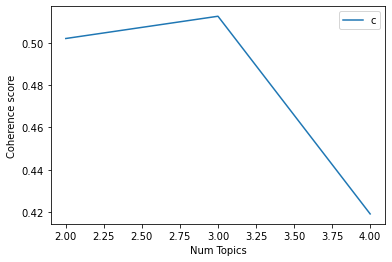

In [217]:
limit=5; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Assign Topic to Each Thought

In [222]:
# Define function.
def assign_topics(text_tokens):
    """
    Takes a set of text tokens and LDA model and returns the best fitting topic.
    """
    text_bow = id2word.doc2bow(text_tokens)
    return sorted(lda_model.get_document_topics(text_bow), key=lambda x: x[1], reverse=True)[0][0]

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [223]:
# Define function.
def topic_fit(text_tokens):
    """
    Takes a set of text tokens and LDA model and returns topic fit.
    """
    text_bow = id2word.doc2bow(text_tokens)
    return sorted(lda_model.get_document_topics(text_bow), key=lambda x: x[1], reverse=True)[0][1]

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [224]:
thoughts['topic'] = thoughts['tokens'].apply(assign_topics)
thoughts['topic_strength'] = thoughts['tokens'].apply(topic_fit)

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Find Most Representative Thought in Each Topic

In [228]:
# find most popular comment for each topic
thoughts = thoughts.sort_values(by='topic_strength', ascending=False)
thoughts[['text', 'topic_strength', 'topic']].groupby('topic').first()

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,topic_strength
topic,,
0,"Meet and chat with new people, especially around weird hobbies, and learn a lot more about those hobbies or weird interests. Like hot sauce, or russian literature, etc.",0.988561
1,I think the best feature is that I can easily communicate with my friends and family. It's much easier when everyone is on the same platform.,0.978187
2,"Easy voice and video chat, easy payments options for sending and receiving money, lots of controls to control the broadcasting of my data",0.985226


### Find Most Popular Thought in Each Topic

In [227]:
# find most popular comment for each topic
thoughts = thoughts.sort_values(by='popularity', ascending=False)
thoughts[['text', 'popularity', 'topic']].groupby('topic').first()

C:\Users\bjane\miniconda3\envs\remesh-lda-env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,popularity
topic,,
0,I like how I can see the latest posts from the people I follow.,0.928571
1,"connection, simplicity, convenience",0.880952
2,Seeing pictures and posts from my friends/family,0.948052
